# Big Data Platforms

## Movie Recommender System - Collaborative Filtering


In [163]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('MovieRecommender').getOrCreate()
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import explode

In [2]:
from pyspark.sql import HiveContext
hive_context = HiveContext(sc)

### Load data

Loading processed data first

In [188]:
df = hive_context.table("akarshsahu.processed_dataset_v3")

In [189]:
df.columns

['Movie_Id',
 'Cust_Id',
 'Rating',
 'tconst',
 'Year',
 'Name',
 'primaryTitle',
 'titleType',
 'runtimeMinutes',
 'startYear',
 'isAdult',
 'genres',
 'averageRating',
 'numVotes',
 'Actor_0',
 'Actor_1',
 'Actor_2',
 'Actor_3',
 'Actor_4',
 'Actor_5',
 'Actor_6',
 'Actor_7',
 'Actor_8',
 'Actor_9',
 'Director_0',
 'Director_1',
 'Director_2',
 'Director_3',
 'Director_4',
 'Director_5',
 'genres_split',
 'Act_Cri_Thr_Myst_Hor',
 'Ad_Fan_Sci_Ani',
 'Bio_War_Hist_Doc',
 'Mus_Musi_Fam',
 'Noir_West',
 'Ad_Rom',
 'Drama_n',
 'Comedy_n',
 'TopActor',
 'TopDirector']

Loading customer clusters

In [5]:
clusters = hive_context.table("mwehr.clustered_customer")

Rename "Cust_Id" to prevent amibuguity

In [6]:
clusters = clusters.withColumnRenamed("Cust_Id", "Cust_Id_cluster")

In [7]:
clusters.show()

+---------------+-------+
|Cust_Id_cluster|cluster|
+---------------+-------+
|         117728|      2|
|        1240047|      2|
|        2227611|      4|
|        1469631|      2|
|         346873|      5|
|         343469|      1|
|        2383395|      4|
|        2631679|      1|
|        1915120|      3|
|        2248947|      1|
|        2422919|      1|
|        2580717|      1|
|        1896000|      2|
|        2559707|      4|
|         481484|      2|
|        1205890|      4|
|        2135677|      1|
|        1500625|      5|
|        2429805|      4|
|        1342040|      1|
+---------------+-------+
only showing top 20 rows



Merging processed data and customer clusters

In [202]:
df = df.join(clusters, df.Cust_Id == clusters.Cust_Id_cluster, how='left')
df.show()

+--------+-------+------+---------+----+---------+------------+---------+--------------+---------+-------+------------------+-------------+--------+-----------+-----------+-------------+------------+-------+-------+-------+-------+-------+-------+---------------+----------+----------+----------+----------+----------+--------------------+--------------------+--------------+----------------+------------+---------+------+-------+--------+--------+-----------+---------------+-------+
|Movie_Id|Cust_Id|Rating|   tconst|Year|     Name|primaryTitle|titleType|runtimeMinutes|startYear|isAdult|            genres|averageRating|numVotes|    Actor_0|    Actor_1|      Actor_2|     Actor_3|Actor_4|Actor_5|Actor_6|Actor_7|Actor_8|Actor_9|     Director_0|Director_1|Director_2|Director_3|Director_4|Director_5|        genres_split|Act_Cri_Thr_Myst_Hor|Ad_Fan_Sci_Ani|Bio_War_Hist_Doc|Mus_Musi_Fam|Noir_West|Ad_Rom|Drama_n|Comedy_n|TopActor|TopDirector|Cust_Id_cluster|cluster|
+--------+-------+------+-----

### Defining ALS_model and ALS_evaluation function

In [9]:
def ALS_model(df, selected_col, train_split=0.8, maxIter=10, regParam=0.1,rank=8,\
              nonnegative=True, coldStartStrategy="drop"):
    """
    Trains ALS model and returns model and predictions on test split
    df = dataframe to evaluate; pyspark dataframe
    selected_col = Columns to use for modeling (1. userCol, 2. itemCol, last ratingCol; list
    train_split = fraction of df to use for training (1-train_split will be used for testing); float
    """
    
    # Add cluster column here
    ratings = df.select(selected_col)
    columns = ratings.columns

    #Split dataset to train and test
    train_data, test_data = ratings.randomSplit([train_split, 1-train_split])

    # Build the recommendation model using ALS on the training data
    als = ALS(maxIter=maxIter, regParam=regParam, rank=rank, nonnegative=nonnegative,\
              coldStartStrategy=coldStartStrategy, userCol=columns[0], itemCol=columns[1], ratingCol=columns[-1])
    model = als.fit(train_data)

    # Make Predictions
    #Let see how the model perform
    predictions = model.transform(test_data)
    
    return model, predictions

In [10]:
def ALS_evaluation(predictions, predictionCol, labelCol, metricName="rmse"):
    """
    Takes result from ALS_model and returns RMSE
    predictions = predictions df from ALS_model; df
    labelCol = Label used for evaluation
    predictionCol = Column used for making prediction
    """
    # Model Evaluation
    # check the root mean squared error
    evaluator = RegressionEvaluator(metricName=metricName, predictionCol=predictionCol, labelCol=labelCol)
    rmse = evaluator.evaluate(predictions)
    
    return rmse

### Training, predicting, and evaluating different customer clusters

Defining parameters

In [11]:
selected_col = ["Cust_Id", "Movie_Id", "Name", "Rating"]
predictionCol = "prediction"
labelCol = "Rating"

Using previously defined functions and dfs to create six different ALS models, respective predictions, and rmse. If else statements are needed here, since models and predictions are too big to store in list or dic

In [13]:
rmse_dic = {}

for clu in range(6):
    if clu==0:
        model_0, predictions_0 = ALS_model(df.filter(df.cluster==clu), selected_col)
        rmse_0 = ALS_evaluation(predictions_0, predictionCol, labelCol)
        rmse_dic["cluster_"+str(clu)] = rmse_0
    elif clu==1:
        model_1, predictions_1 = ALS_model(df.filter(df.cluster==clu), selected_col)
        rmse_1 = ALS_evaluation(predictions_1, predictionCol, labelCol)
        rmse_dic["cluster_"+str(clu)] = rmse_1
    elif clu==2:
        model_2, predictions_2 = ALS_model(df.filter(df.cluster==clu), selected_col)
        rmse_2 = ALS_evaluation(predictions_2, predictionCol, labelCol)
        rmse_dic["cluster_"+str(clu)] = rmse_2
    elif clu==3:
        model_3, predictions_3 = ALS_model(df.filter(df.cluster==clu), selected_col)
        rmse_3 = ALS_evaluation(predictions_3, predictionCol, labelCol)
        rmse_dic["cluster_"+str(clu)] = rmse_3
    elif clu==4:
        model_4, predictions_4 = ALS_model(df.filter(df.cluster==clu), selected_col)
        rmse_4 = ALS_evaluation(predictions_4, predictionCol, labelCol)
        rmse_dic["cluster_"+str(clu)] = rmse_4
    else:
        model_5, predictions_5 = ALS_model(df.filter(df.cluster==clu), selected_col)
        rmse_5 = ALS_evaluation(predictions_5, predictionCol, labelCol)
        rmse_dic["cluster_"+str(clu)] = rmse_5
    

In [14]:
rmse_dic

{'cluster_0': 1.137202037020864,
 'cluster_1': 0.8644858135806135,
 'cluster_2': 0.8468156697272107,
 'cluster_3': 0.8009100242155416,
 'cluster_4': 0.8397982474230333,
 'cluster_5': 0.8886375953453536}

### Explore recommendations for different clusters by user

Start by creating function for plotting top movies, actors, directors, years

In [99]:
def plt_top_userRecs(model, df, cols, title, x, y, plt_type="bar", color="blue"):
    """
    Takes recommendation model, user dataframe, and plot specifications and returns bar plot of
    top 10 recommended movies for a given cluster
    
    model=recommendation model; als
    df=df with movie information; pyspark dataframe
    cols=columns from df relevant for plotting; list of str
    title=plot title; str
    x=x-axis; str
    y=y-axis; str
    plt_type=type of plot from pandas.plot(); str
    """
    
    userRecs = model.recommendForAllUsers(10)

    rec_movies = []

    for lst in userRecs.toPandas().recommendations:
        for tup in lst:
            rec_movies.append(tup[0])

    movies = spark.createDataFrame(rec_movies, IntegerType()).groupBy("value").count().orderBy("count", ascending=False)

    movies = movies.join(df.select(cols).distinct(),movies.value == df.Movie_Id, how='left')
    
    movies = movies.na.drop()

    if plt_type=="bar":
        return movies.orderBy("count", ascending=False).limit(10).toPandas()[[x,y]]\
                .plot(kind=plt_type, x=x, y=y, title=title, color=color)
    elif plt_type=="hist":
        return movies.toPandas()[x].plot(kind=plt_type, x=x, title=title, color=color)

#### Plotting top ten movies recommended for each cluster

Defining global parameters

In [50]:
cols = ["Movie_Id","Name","Year","runtimeMinutes","Actor_0","Director_0"]
plot_x_y = ["Name","count"]

##### Cluster 0

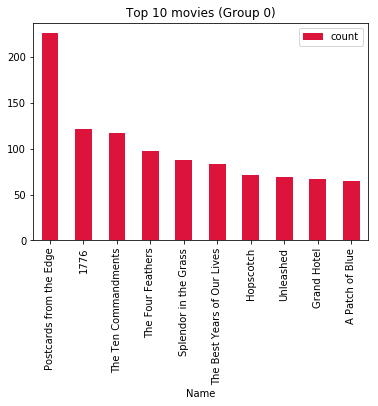

In [73]:
color_0 = "crimson"

plt_top_userRecs(model_0, df, cols, title="Top 10 movies (Group 0)", x="Name",y="count", color=color_0)

##### Cluster 1

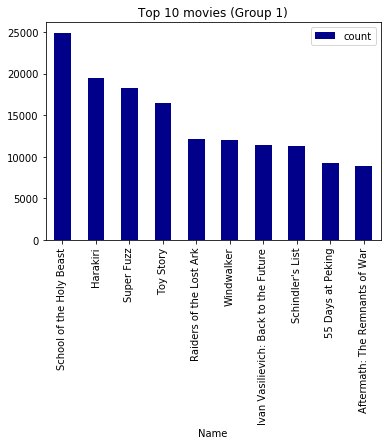

In [74]:
color_1 = "darkblue"

plt_top_userRecs(model_1, df, cols, title="Top 10 movies (Group 1)", x="Name",y="count", color=color_1)

##### Cluster 2

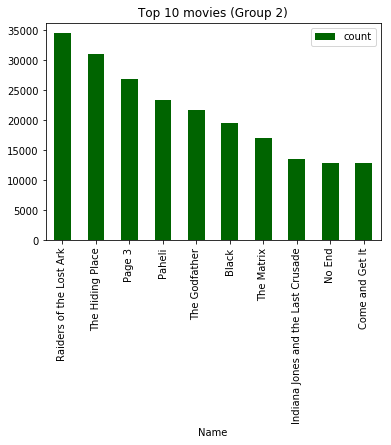

In [75]:
color_2 = "darkgreen"

plt_top_userRecs(model_2, df, cols, title="Top 10 movies (Group 2)", x="Name",y="count",color=color_2)

##### Cluster 3

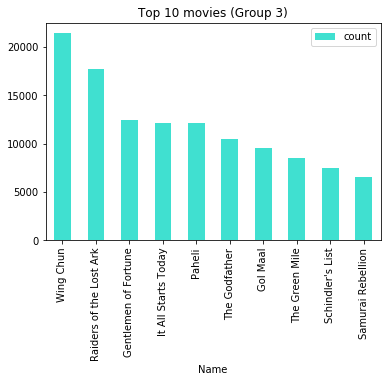

In [76]:
color_3 = "turquoise"

plt_top_userRecs(model_3, df, cols, title="Top 10 movies (Group 3)", x="Name",y="count",color=color_3)

##### Cluster 4

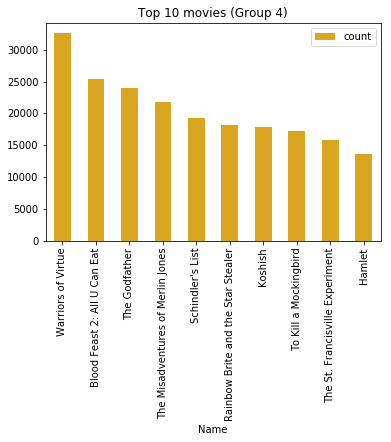

In [77]:
color_4 = "goldenrod"

plt_top_userRecs(model_4, df, cols, title="Top 10 movies (Group 4)", x="Name",y="count",color=color_4)

##### Cluster 5

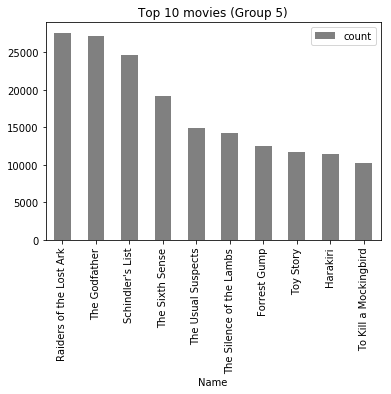

In [78]:
color_5 = "grey"

plt_top_userRecs(model_5, df, cols, title="Top 10 movies (Group 5)", x="Name",y="count",color=color_5)

#### Plotting top ten most popular actors for each cluster

##### Cluster 0

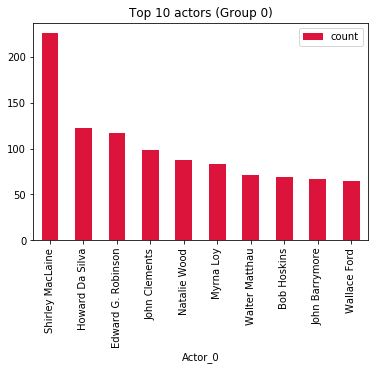

In [79]:
plt_top_userRecs(model_0, df, cols, title="Top 10 actors (Group 0)", x="Actor_0",y="count",color=color_0)

##### Cluster 1

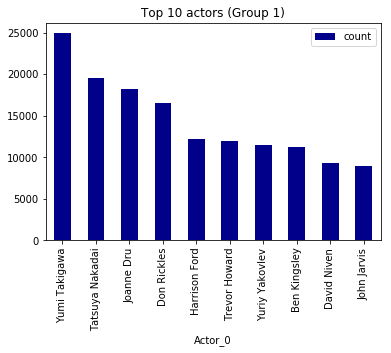

In [80]:
plt_top_userRecs(model_1, df, cols, title="Top 10 actors (Group 1)", x="Actor_0",y="count",color=color_1)

##### Cluster 2

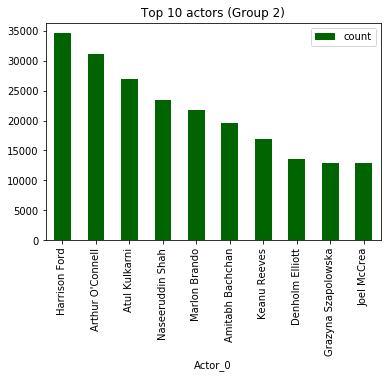

In [81]:
plt_top_userRecs(model_2, df, cols, title="Top 10 actors (Group 2)", x="Actor_0",y="count",color=color_2)

##### Cluster 3

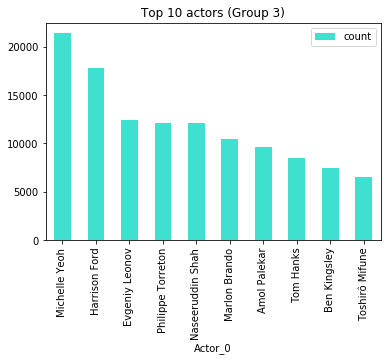

In [82]:
plt_top_userRecs(model_3, df, cols, title="Top 10 actors (Group 3)", x="Actor_0",y="count",color=color_3)

##### Cluster 4

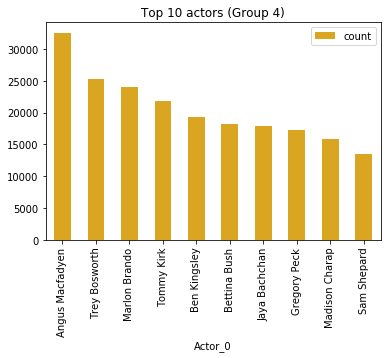

In [83]:
plt_top_userRecs(model_4, df, cols, title="Top 10 actors (Group 4)", x="Actor_0",y="count",color=color_4)

##### Cluster 5

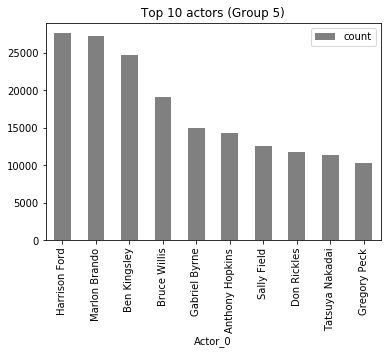

In [84]:
plt_top_userRecs(model_5, df, cols, title="Top 10 actors (Group 5)", x="Actor_0",y="count",color=color_5)

#### Top 10 most popular directors per customer cluster

##### Cluster 0

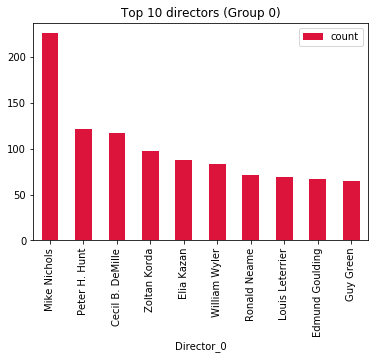

In [85]:
plt_top_userRecs(model_0, df, cols, title="Top 10 directors (Group 0)", x="Director_0",y="count",color=color_0)

##### Cluster 1

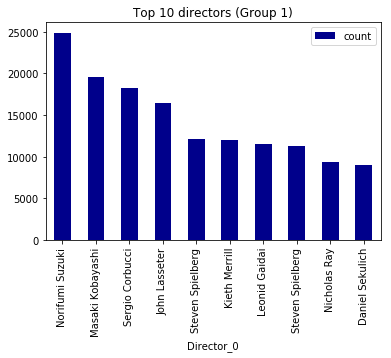

In [86]:
plt_top_userRecs(model_1, df, cols, title="Top 10 directors (Group 1)", x="Director_0",y="count",color=color_1)

##### Cluster 2

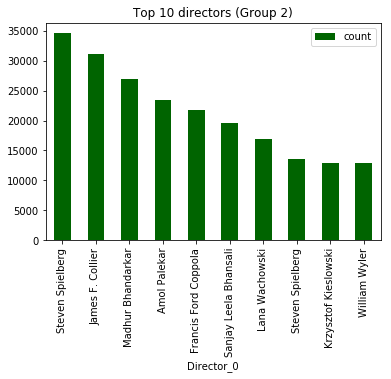

In [87]:
plt_top_userRecs(model_2, df, cols, title="Top 10 directors (Group 2)", x="Director_0",y="count",color=color_2)

##### Cluster 3

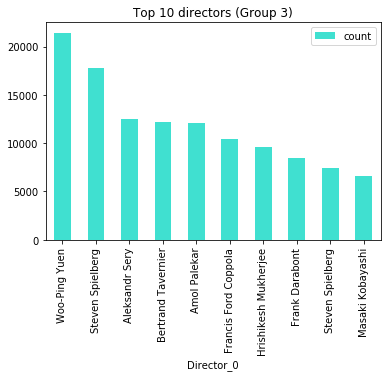

In [88]:
plt_top_userRecs(model_3, df, cols, title="Top 10 directors (Group 3)", x="Director_0",y="count",color=color_3)

##### Cluster 4

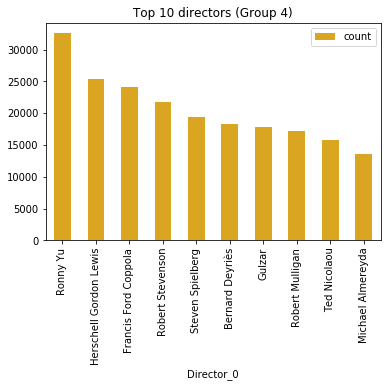

In [89]:
plt_top_userRecs(model_4, df, cols, title="Top 10 directors (Group 4)", x="Director_0",y="count",color=color_4)

##### Cluster 5

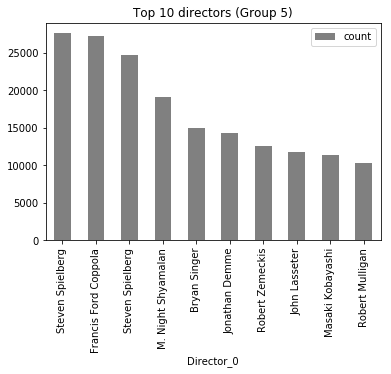

In [90]:
plt_top_userRecs(model_5, df, cols, title="Top 10 directors (Group 5)", x="Director_0",y="count",color=color_5)

#### Runtime histogram per customer cluster

##### Cluster 0

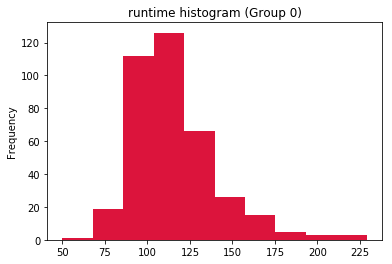

In [102]:
plt_top_userRecs(model_0, df, cols, title="runtime histogram (Group 0)", x="runtimeMinutes",\
                 y="count",plt_type="hist",color=color_0)

##### Cluster 1

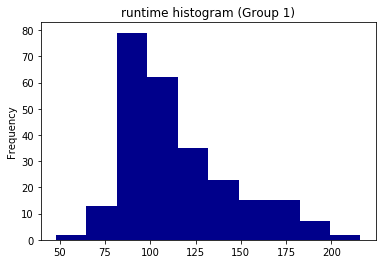

In [101]:
plt_top_userRecs(model_1, df, cols, title="runtime histogram (Group 1)", x="runtimeMinutes",\
                 y="count",plt_type="hist",color=color_1)

##### Cluster 2

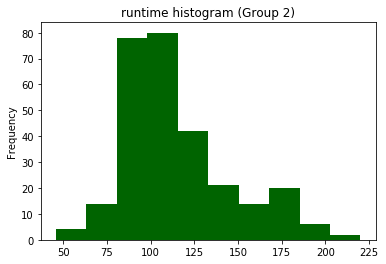

In [103]:
plt_top_userRecs(model_2, df, cols, title="runtime histogram (Group 2)", x="runtimeMinutes",\
                 y="count",plt_type="hist",color=color_2)

##### Cluster 3

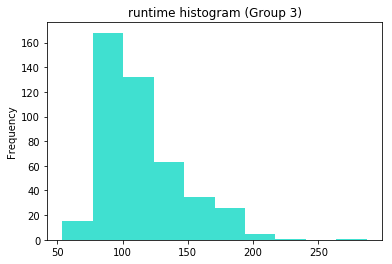

In [104]:
plt_top_userRecs(model_3, df, cols, title="runtime histogram (Group 3)", x="runtimeMinutes",\
                 y="count",plt_type="hist",color=color_3)

##### Cluster 4

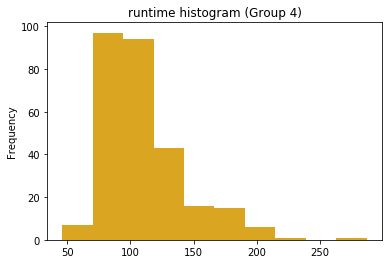

In [105]:
plt_top_userRecs(model_4, df, cols, title="runtime histogram (Group 4)", x="runtimeMinutes",\
                 y="count",plt_type="hist",color=color_4)

##### Cluster 5

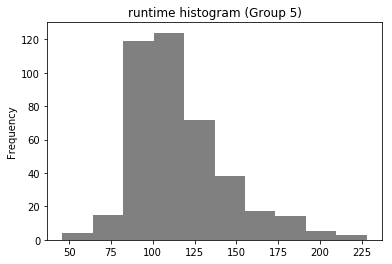

In [106]:
plt_top_userRecs(model_5, df, cols, title="runtime histogram (Group 5)", x="runtimeMinutes",\
                 y="count",plt_type="hist",color=color_5)

#### Distribution of year of creation of the movies per customer cluster

##### Cluster 0

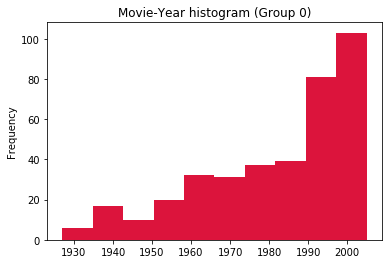

In [113]:
plt_top_userRecs(model_0, df, cols, title="Movie-Year histogram (Group 0)", x="Year",\
                 y="count",plt_type="hist",color=color_0)

##### Cluster 1

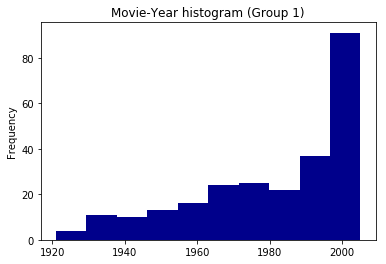

In [114]:
plt_top_userRecs(model_1, df, cols, title="Movie-Year histogram (Group 1)", x="Year",\
                 y="count",plt_type="hist",color=color_1)

##### Cluster 2

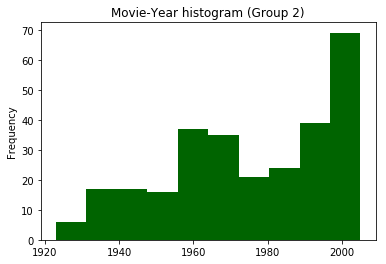

In [115]:
plt_top_userRecs(model_2, df, cols, title="Movie-Year histogram (Group 2)", x="Year",\
                 y="count",plt_type="hist",color=color_2)

##### Cluster 3

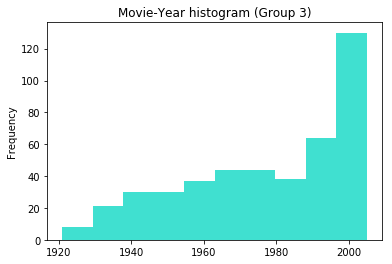

In [116]:
plt_top_userRecs(model_3, df, cols, title="Movie-Year histogram (Group 3)", x="Year",\
                 y="count",plt_type="hist",color=color_3)

##### Cluster 4

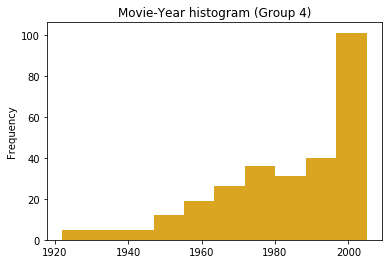

In [117]:
plt_top_userRecs(model_4, df, cols, title="Movie-Year histogram (Group 4)", x="Year",\
                 y="count",plt_type="hist",color=color_4)

##### Cluster 5

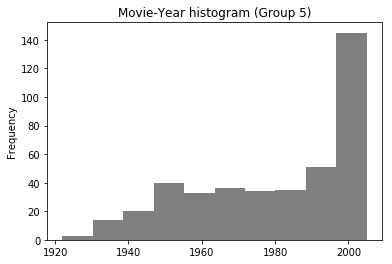

In [118]:
plt_top_userRecs(model_5, df, cols, title="Movie-Year histogram (Group 5)", x="Year",\
                 y="count",plt_type="hist",color=color_5)

### Create customer-cluster-recommendation table

Start by defining a function that gets the movie names for the top five recommendations for each customer

In [206]:
def get_movie_names(model, df):
    userRecs = model.recommendForAllUsers(5)
    tabel = userRecs.select(userRecs.Cust_Id,explode(userRecs.recommendations))
    tabel = tabel.select(tabel.Cust_Id, tabel.col.Movie_Id.alias("rec_movie_Id"))
    tabel = tabel.join(df.select(df.Name, df.Movie_Id).distinct(),tabel.rec_movie_Id == df.Movie_Id, how='left')
    
    tabel = tabel.join(df.select(df.Cust_Id_cluster, df.cluster).distinct(),tabel.Cust_Id == df.Cust_Id_cluster, how='left')
    tabel = tabel.drop("Cust_Id_cluster")
    tabel = tabel.drop("Movie_Id")
    
    return tabel

Looping over all different models

In [207]:
cust_rec_movies = get_movie_names(model_0, df)

models = [model_1, model_2, model_3, model_4, model_5]

for mod in models:
    mod1 = get_movie_names(mod, df)
    cust_rec_movies = cust_rec_movies.union(mod1)

In [208]:
cust_rec_movies.show()

+-------+------------+--------------------+-------+
|Cust_Id|rec_movie_Id|                Name|cluster|
+-------+------------+--------------------+-------+
|2349833|        4001|   The Four Feathers|      0|
|2349833|        8700|           Hopscotch|      0|
|2349833|        9576|To the Shores of ...|      0|
|2349833|       14943|                1776|      0|
|2349833|        8253|         Brain Drain|      0|
|2428331|       14642|           High Noon|      0|
|2428331|       14776|The Ten Commandments|      0|
|2428331|        3269|     The Longest Day|      0|
|2428331|        5010|Postcards from th...|      0|
|2428331|         953|      Fahrenheit 451|      0|
|2518468|       12210|        Grey Gardens|      0|
|2518468|        1824|Sun Ra: A Joyful ...|      0|
|2518468|       14862|Once Upon a Time ...|      0|
|2518468|        5010|Postcards from th...|      0|
|2518468|       13979|     A Patch of Blue|      0|
|1628321|       10043|  After the Thin Man|      0|
|1628321|   

Saving dataframe into directories

In [211]:
cust_rec_movies.write.saveAsTable("akarshsahu.cust_rec_movies")
cust_rec_movies.write.saveAsTable("aghose.cust_rec_movies")
cust_rec_movies.write.saveAsTable("mwehr.cust_rec_movies")

### Analyzing cluster size

Finally, comparing the size of different clusters using a pie plot

In [233]:
cluster = ["cluster_"+str(x) for x in range(6)]
count = [cust_rec_movies.filter(cust_rec_movies.cluster==x).count()/5 for x in range(6)]

cluster_size = {"cluster": cluster, "count": count}

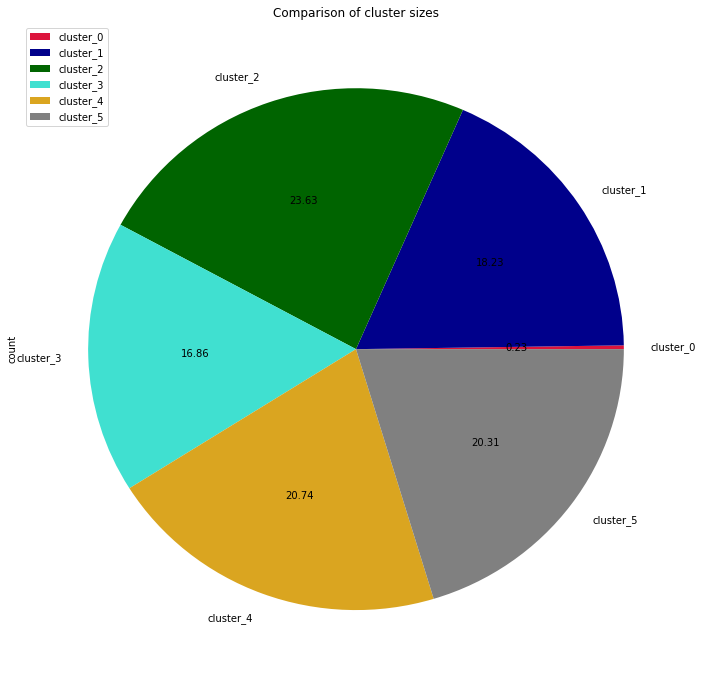

In [246]:
import pandas as pd

pd.DataFrame(cluster_size).plot(kind="pie", title="Comparison of cluster sizes",\
                                y="count", labels=cluster, figsize=(12,12),\
                               colors=[color_0,color_1,color_2,color_3,color_4,color_5],\
                               autopct='%.2f')